<a href="https://colab.research.google.com/github/jayeshmanani/TensorFlow/blob/master/transfer_learning_tf_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-gpu==2.0.0b1"

     |████████████████████████████████| 348.9MB 54kB/s 
     |████████████████████████████████| 501kB 16.7MB/s 
     |████████████████████████████████| 3.1MB 62.0MB/s 


In [2]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ",tf.__version__)
print("Eager Mode: ",tf.executing_eagerly())
print("Hub Version: ",hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "Not Available")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Version:  2.0.0-beta1
Eager Mode:  True
Hub Version:  0.7.0
GPU is available


### **Select the Hub/TF2 module to use**

#### Hub module for TF 1.x won't work here, please use the one of the selection provided

In [28]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


### **Data Preprocessing**
##### Use tensorflow datasets for loading the cat and dogs dataset.
##### This tfds package is the best way to import pre-defined data.

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80,10,10))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

#### Formating the data

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [0]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1) 
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

##### Inspecting a Batch

In [35]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

### **Defining the Model**

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

In [0]:
# load TFHub model
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape = [FV_SIZE],
                                   trainable=do_fine_tuning)

In [39]:
print("Build Model With", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Build Model With https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 7 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
  feature_extractor.trainable = True
  
  for layer in model.layers[-NUM_LAYERS:]:
    layer.trainable = True

else:
  feature_extractor.trainable = False

## Training the model

In [0]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [42]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 48s 82ms/step - loss: 0.0524 - accuracy: 0.9831 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
582/582 [==============================] - 40s 69ms/step - loss: 0.0309 - accuracy: 0.9900 - val_loss: 0.0396 - val_accuracy: 0.9862
Epoch 3/5
582/582 [==============================] - 40s 69ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.0408 - val_accuracy: 0.9853
Epoch 4/5
582/582 [==============================] - 40s 68ms/step - loss: 0.0219 - accuracy: 0.9936 - val_loss: 0.0425 - val_accuracy: 0.9858
Epoch 5/5
582/582 [==============================] - 40s 69ms/step - loss: 0.0193 - accuracy: 0.9944 - val_loss: 0.0443 - val_accuracy: 0.9853


## Export the model

In [0]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

Export the SavedModel

In [44]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [45]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [47]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense_1': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_1')}


## Convert using TFLite's Converter

Load the TFLiteConverter with the SavedModel

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

### Post-training quantization
The simplest form of post-training quantization quantizes weights from floating point to 8-bits of precision. This technique is enabled as an option in the TensorFlow Lite converter. At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, hybrid operators dynamically quantize activations to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point, so that the speedup with hybrid ops is less than a full fixed-point computation.

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

### Post-training integer quantization
We can get further latency improvements, reductions in peak memory usage, and access to integer only hardware accelerators by making sure all model math is quantized. To do this, we need to measure the dynamic range of activations and inputs with a representative data set. You can simply create an input data generator and provide it to our converter.

In [0]:
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

In [0]:
converter.representative_dataset = representative_data_gen

The resulting model will be fully quantized but still take float input and output for convenience.

Ops that do not have quantized implementations will automatically be left in floating point. This allows conversion to occur smoothly but may restrict deployment to accelerators that support float. 

### Full integer quantization

To require the converter to only output integer operations, one can specify:

In [0]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

### Finally convert the model

In [53]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Converted 262 variables to const ops.


INFO:tensorflow:Converted 262 variables to const ops.


##Test the TFLite model using the Python Interpreter

In [0]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [55]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

10it [00:15,  1.58s/it]


In [0]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)



NOTE: Colab runs on server CPUs. At the time of writing this, TensorFlow Lite doesn't have super optimized server CPU kernels. For this reason post-training full-integer quantized models  may be slower here than the other kinds of optimized models. But for mobile CPUs, considerable speedup can be observed.

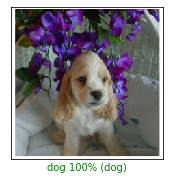

In [68]:
#@title Visualize the outputs { run: "auto" }
index = 9 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()


Download the model.

**NOTE: You might have to run to the cell below twice**

In [0]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

try:
  from google.colab import files
  files.download('converted_model.tflite')
  files.download('labels.txt')
except:
  pass

# Prepare the test images for download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [0]:
!mkdir -p test_images

In [0]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [72]:
!ls test_images

cat_12.jpg  cat_27.jpg	cat_40.jpg  dog_0.jpg	dog_24.jpg  dog_47.jpg
cat_13.jpg  cat_28.jpg	cat_41.jpg  dog_10.jpg	dog_30.jpg  dog_48.jpg
cat_15.jpg  cat_29.jpg	cat_43.jpg  dog_11.jpg	dog_33.jpg  dog_5.jpg
cat_16.jpg  cat_2.jpg	cat_44.jpg  dog_14.jpg	dog_34.jpg  dog_7.jpg
cat_19.jpg  cat_31.jpg	cat_45.jpg  dog_17.jpg	dog_36.jpg  dog_9.jpg
cat_1.jpg   cat_32.jpg	cat_49.jpg  dog_18.jpg	dog_38.jpg
cat_20.jpg  cat_35.jpg	cat_4.jpg   dog_21.jpg	dog_39.jpg
cat_25.jpg  cat_37.jpg	cat_6.jpg   dog_22.jpg	dog_42.jpg
cat_26.jpg  cat_3.jpg	cat_8.jpg   dog_23.jpg	dog_46.jpg


In [0]:
!zip -qq cats_vs_dogs_test_images.zip -r test_images/

In [0]:
try:
  files.download('cats_vs_dogs_test_images.zip')
except:
  pass